In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import random
from scipy.stats import laplace_asymmetric
from sklearn.metrics import mean_absolute_error as mae

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal

# CVXPY
from solardatatools.signal_decompositions import tl1_l1d1_l2d2p365 as cvx_sd
# OSD
from solardatatools.osd_signal_decompositions import tl1_l1d1_l2d2p365 as osd_sd

np.random.seed(5) 
random.seed(5)

In [2]:
%load_ext autoreload
%autoreload 2

## `tl1_l1d1_l2d2p365`

### Create input signal

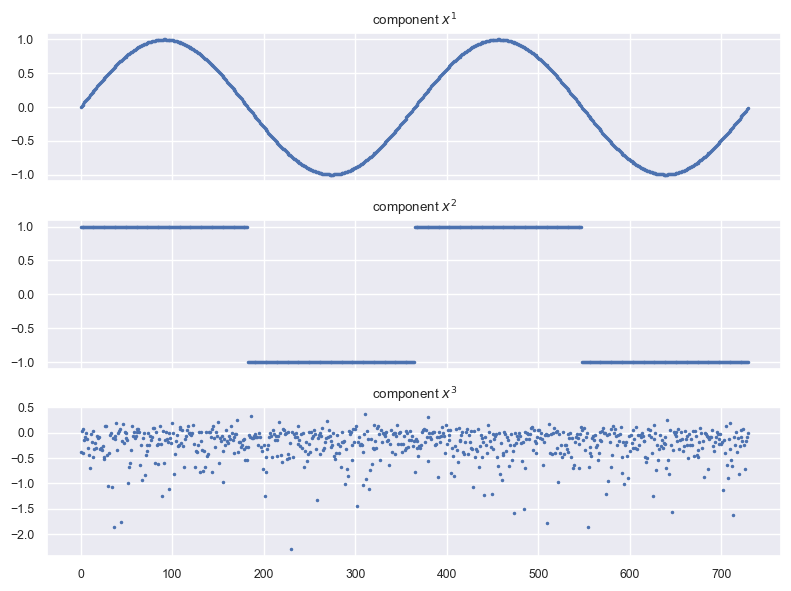

In [3]:
t = np.arange(365*2)

# seasonal term
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# piecewise constant term
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
# asymmetric laplace noise 
kappa = 2 # k>0, k=1 is laplace
signal3 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

In [4]:
indices_full = list(range(len(X_real[1])))
# select 20% randomly
indices_20perc = np.random.choice(indices_full, 200, replace=False)

X_real_80perc = X_real.copy()
y_80perc = y.copy()

X_real_80perc[0][indices_20perc] = np.nan
X_real_80perc[1][indices_20perc] = np.nan
y_80perc[indices_20perc] = np.nan

In [5]:
indices_chunks_start = np.random.choice(indices_full, 5, replace=False)
X_real_chunks= X_real.copy()
y_chunks = y.copy()

for e in indices_chunks_start:
    for i in range(e, e+25):
        X_real_chunks[0][i] = np.nan
        X_real_chunks[1][i] = np.nan
        y_chunks[i] = np.nan

# MOSEK+LinearTerm/MOSEK

CVXPY objective       118.47937
OSD objective, scaled 117.22389
s_hat MAE (OSD,CVX)   4.08e-02
s_seas MAE (OSD,CVX)   4.46e-02


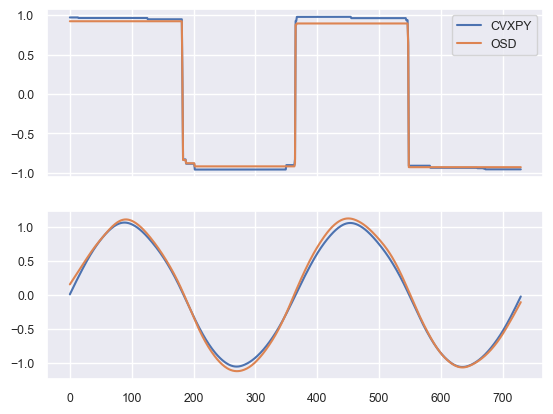

In [28]:
s_hat_cvxpy_mosek, s_seas_cvxpy_mosek = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, solver="MOSEK")
s_hat_osd_mosek, s_seas_osd_mosek = osd_sd(y, tau=0.8, w1=5, w2=1e5, w3=1e2, linear_term=True, solver="MOSEK")

obj_osd_scaled = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, comp_osd=[s_hat_osd_mosek, s_seas_osd_mosek]) 
print(f's_hat MAE (OSD,CVX)   {mae(s_hat_cvxpy_mosek, s_hat_osd_mosek):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(s_seas_cvxpy_mosek, s_seas_osd_mosek):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(s_hat_cvxpy_mosek, label="CVXPY")
ax1.plot(s_hat_osd_mosek, label="OSD")
ax2.plot(s_seas_cvxpy_mosek)
ax2.plot(s_seas_osd_mosek)
ax1.legend()
plt.show()

# MOSEK/QSS

CVXPY objective       118.47937
OSD objective, scaled 117.20708
s_hat MAE (OSD,CVX)   9.42e-02
s_seas MAE (OSD,CVX)   4.62e-02


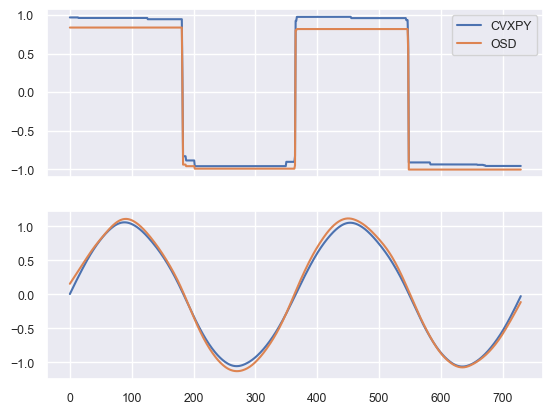

In [27]:
s_hat_cvxpy_mosek, s_seas_cvxpy_mosek = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, solver="MOSEK")
s_hat_osd_mosek, s_seas_osd_mosek = osd_sd(y, tau=0.8, w1=5, w2=1e5, w3=1e2, linear_term=True, solver="QSS")

obj_osd_scaled = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, comp_osd=[s_hat_osd_mosek, s_seas_osd_mosek]) 
print(f's_hat MAE (OSD,CVX)   {mae(s_hat_cvxpy_mosek, s_hat_osd_mosek):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(s_seas_cvxpy_mosek, s_seas_osd_mosek):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(s_hat_cvxpy_mosek, label="CVXPY")
ax1.plot(s_hat_osd_mosek, label="OSD")
ax2.plot(s_seas_cvxpy_mosek)
ax2.plot(s_seas_osd_mosek)
ax1.legend()
plt.show()

without linear term

CVXPY objective       118.85334
OSD objective, scaled 118.85334
s_hat MAE (OSD,CVX)   1.88e-10
s_seas MAE (OSD,CVX)   2.19e-10


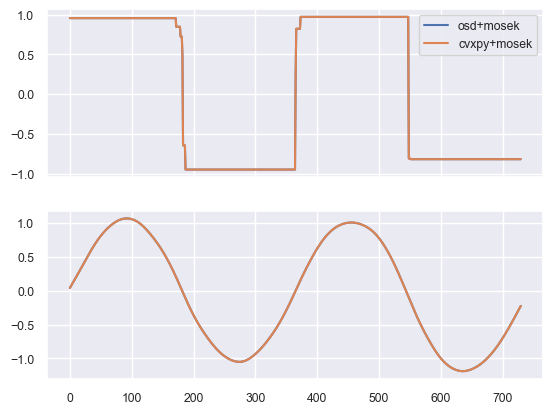

In [6]:
w_osd = { 'w1' : 5,
          'w2' : 1e5,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="MOSEK", linear_term=False)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=False, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+mosek")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+mosek")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

with linear term

CVXPY objective       119.37732
OSD objective, scaled 118.59797
s_hat MAE (OSD,CVX)   1.05e-03
s_seas MAE (OSD,CVX)   4.10e-04


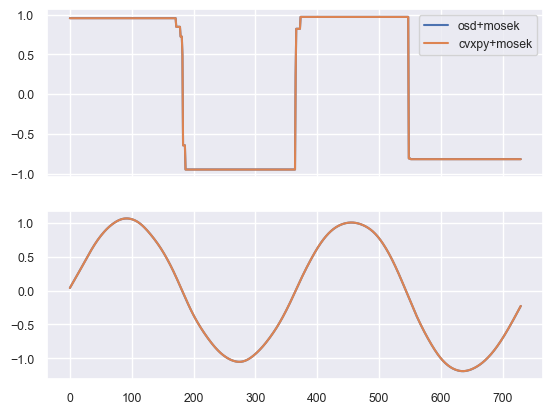

In [7]:
w_osd = { 'w1' : 5,
          'w2' : 1e5,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="MOSEK", linear_term=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=True, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+mosek")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+mosek")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

with QSS + linear term

CVXPY objective       134.62617
OSD objective, scaled 133.41056
s_hat MAE (OSD,CVX)   5.63e-03
s_seas MAE (OSD,CVX)   4.28e-03


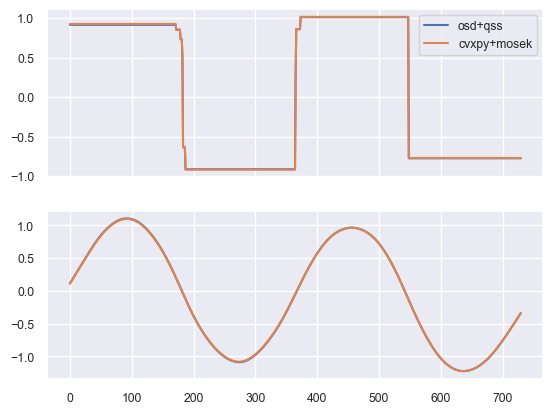

In [8]:
w_osd = { 'w1' : 7,
          'w2' : 2e5,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 7,
          'c2' : 2e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=True, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

with SumCard

CVXPY objective       149.14411
OSD objective, scaled 145.03447
s_hat MAE (OSD,CVX)   6.14e-02
s_seas MAE (OSD,CVX)   7.66e-04


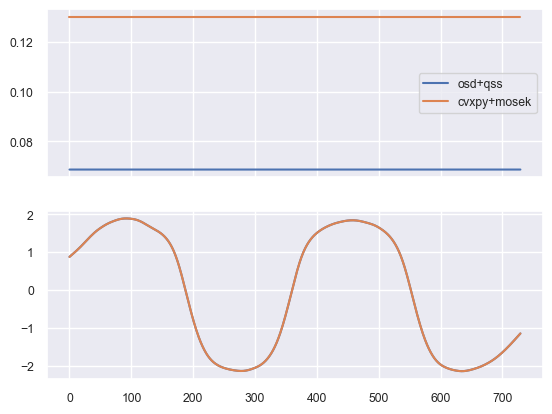

In [9]:
w_osd = { 'w1' : 50,
          'w2' : 3e4,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 50,
          'c2' : 3e4,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=True, sum_card=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=True, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();